# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [108]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [109]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [7]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [110]:
class Controller:
    def __init__(self):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.K = np.array([[-3.78701535857112e-16, -3.16227766016838, 4.96812722514226e-15, 1.41876312532732e-15, -8.94508225632956, -1.98994821346822e-15], 
                           [-1.02982371392575e-16, -4.53064843404049e-16, 7.74596669241483, 20.3486695513446, -3.51901814918395e-15, -1.95906707059117e-15], 
                           [3.78701535857112e-16, 3.16227766016838, -4.01951989352548e-15, 1.07323017796882e-15, 8.94508225632956, 1.98994821346822e-15], 
                           [2.23606797749979, 6.33060947260181e-16, -8.52658575547852e-16, -2.84011975230725e-15, 2.19713230167733e-15, 11.2536432343609]], dtype=float)
        
        self.L = np.array([[-0.625109168105708, 0.00939777301889200, -0.600083339596343, 4.13386338148511e-17, -0.625109168105708, -0.00939777301889196, -0.318837215835956, 4.13386338148511e-17, -0.309439442817064, 2.04633117976011e-17], 
                           [-4.13386338148511e-17, 0.412087923966302, -6.89170921027554e-17, 0.832472864454040, -4.13386338148511e-17, 0.412087923966302, -6.46807754382456e-18, 0.832472864454040, -2.04633117976011e-17, 0.412087923966302], 
                           [-0.189214369047960, 0.775351286864255, 1.36337404962892, -2.81779461334441e-16, -0.189214369047960, -0.775351286864256, -0.869015548914051, -2.81779461334441e-16, -0.0936642620497959, -1.39485523427609e-16], 
                           [-0.0754853592604742, 0.320201998225909, 0.565670977957817, 4.71342761013303e-17, -0.0754853592604742, -0.320201998225909, -0.357568507472910, 4.71342761013303e-17, -0.0373665092470010, 2.33322511947463e-17], 
                           [-5.14403078830304e-17, 0.265729329191658, -2.15764619002347e-16, 0.536808877368897, -5.14403078830304e-17, 0.265729329191658, 5.69546923046477e-17, 0.536808877368897, -2.54638085982630e-17, 0.265729329191658], 
                           [-0.711637579283912, 0.00411049994551448, -0.696323893246931, 7.81500515128997e-17, -0.711637579283912, -0.00411049994551440, -0.356382946514495, 7.81500515128997e-17, -0.352272446568980, 3.86855762643160e-17]], dtype=float)
        
        self.A = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                           [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], 
                           [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 
                           [0.0, 0.0, 0.0, 0.0, -0.0, -0.0], 
                           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=float)
        self.B = np.array([[0.0, 0.0, 0.0, 0.0], 
                           [0.0, 0.0, 0.0, 0.0], 
                           [0.0, 0.0, 0.0, 0.0], 
                           [-2.347640753661179e-18, 0.03833988306335666, 7.042922260983532e-18, -1.660032696703717e-18], 
                           [-0.0421555539883151, -5.16256642580734e-18, 0.0421555539883151, 1.82524286400719e-18], 
                           [0.0, 0.0, 0.0, 0.03833988306335666]], dtype=float)
        
        self.C = np.array([[-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], 
                           [0.0, 2.62500000000000, 0.263378514224308, 0.0, 0.0, 0.0], 
                           [-2.62500000000000, 0.0, 0.263378514224308, 0.0, 0.0, 0.0], 
                           [0.0, 2.65142599685905, 0.0, 0.0, 0.0, 0.0], 
                           [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], 
                           [0.0, 2.62500000000000, -0.263378514224308, 0.0, 0.0, 0.0], 
                           [-2.62500000000000, 0.0, -0.263378514224308, 0.0, 0.0, 0.0], 
                           [0.0, 2.65142599685905, 0.0, 0.0, 0.0, 0.0], 
                           [-2.62500000000000, 0.0, 0.0, 0.0, 0.0, 0.0], 
                           [0.0, 2.62500000000000, 0.0, 0.0, 0.0, 0.0]], dtype=float)
        
        self.G = np.array([0.2633785142243077, 0.0, 0.0, 0.26337851422430775, -0.2633785142243077, 0.0, 0.0, -0.26337851422430775, 0.0, 0.0], dtype=float)
        
        self.psi_e = 0
        self.theta_e = 0
        self.phi_e = 0
        self.w_x_e = 0
        self.w_y_e = 0
        self.w_z_e = 0
        self.tau_1_e = self.tau_2_e = self.tau_3_e = self.tau_4_e = 0  

        self.dt = 0.01

        #self.variables_to_log = [K, L, A, B, C, G, psi_e, theta_e, phi_e, w_x_e,
        #                         w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e, dt]
    
    def reset(self):
        self.xhat = np.array([0, 0, 0, 0, 0, 0], dtype=float)
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        
        
        
        # FIXME: replace the following lines

        u = -self.K @ self.xhat

        torque_1 = u[0] + self.tau_1_e
        torque_2 = u[1] + self.tau_2_e
        torque_3 = u[2] + self.tau_3_e
        torque_4 = u[3] + self.tau_4_e
        
        y = star_measurements - self.G
        #print('measured:', star_measurements)
        #print('equil:', self.G)
        
        self.xhat += self.dt*(self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))


        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [111]:
controller = Controller()

You could reset the simulator with given initial conditions.

In [112]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [113]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [114]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [115]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

measured: [ 0.16546041 -0.06561119  0.12834786  0.26102934 -0.03583288 -0.25729563
  0.21248065 -0.19458475  0.118328   -0.02582528]
equil: [ 0.26337851  0.          0.          0.26337851 -0.26337851  0.
  0.         -0.26337851  0.          0.        ]
measured: [ 0.27196222  0.03418682  0.07032413  0.2747941  -0.14542419 -0.23264689
  0.12790267 -0.37279205  0.218265   -0.09647169]
equil: [ 0.26337851  0.          0.          0.26337851 -0.26337851  0.
  0.         -0.26337851  0.          0.        ]
measured: [ 0.32450895 -0.21073823  0.0941418   0.22806896 -0.20996207 -0.15023055
  0.0453741  -0.43105974 -0.0537947  -0.05657612]
equil: [ 0.26337851  0.          0.          0.26337851 -0.26337851  0.
  0.         -0.26337851  0.          0.        ]
measured: [ 0.31551319 -0.14337548  0.20053817  0.06231621 -0.35041888 -0.43041734
  0.19146818 -0.42639213  0.18353629 -0.01882653]
equil: [ 0.26337851  0.          0.          0.26337851 -0.26337851  0.
  0.         -0.26337851  0.  

Check if the space-cat has docked.

In [116]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


Get, show, and save a snapshot of the simulation after the last time step.

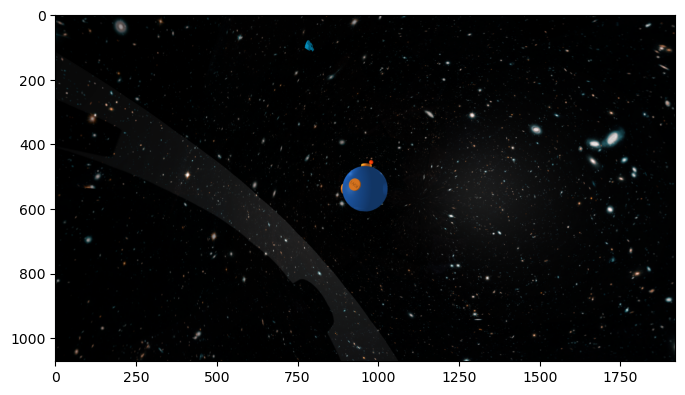

In [54]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

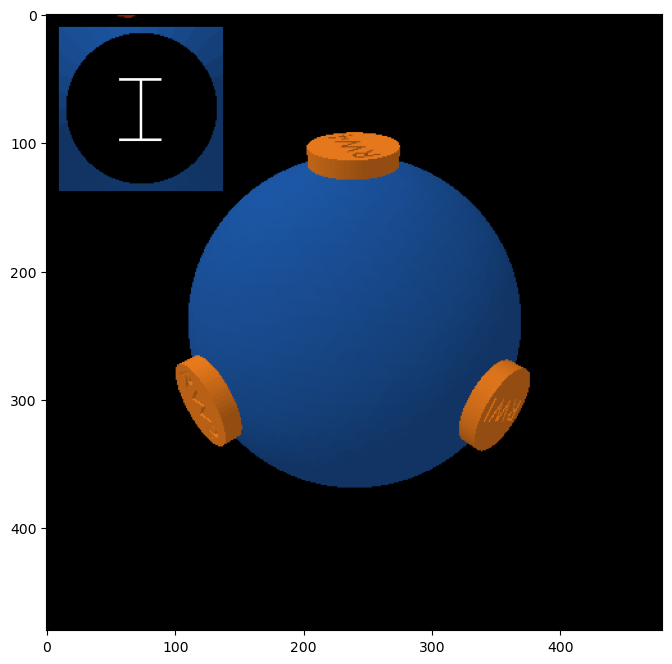

In [55]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

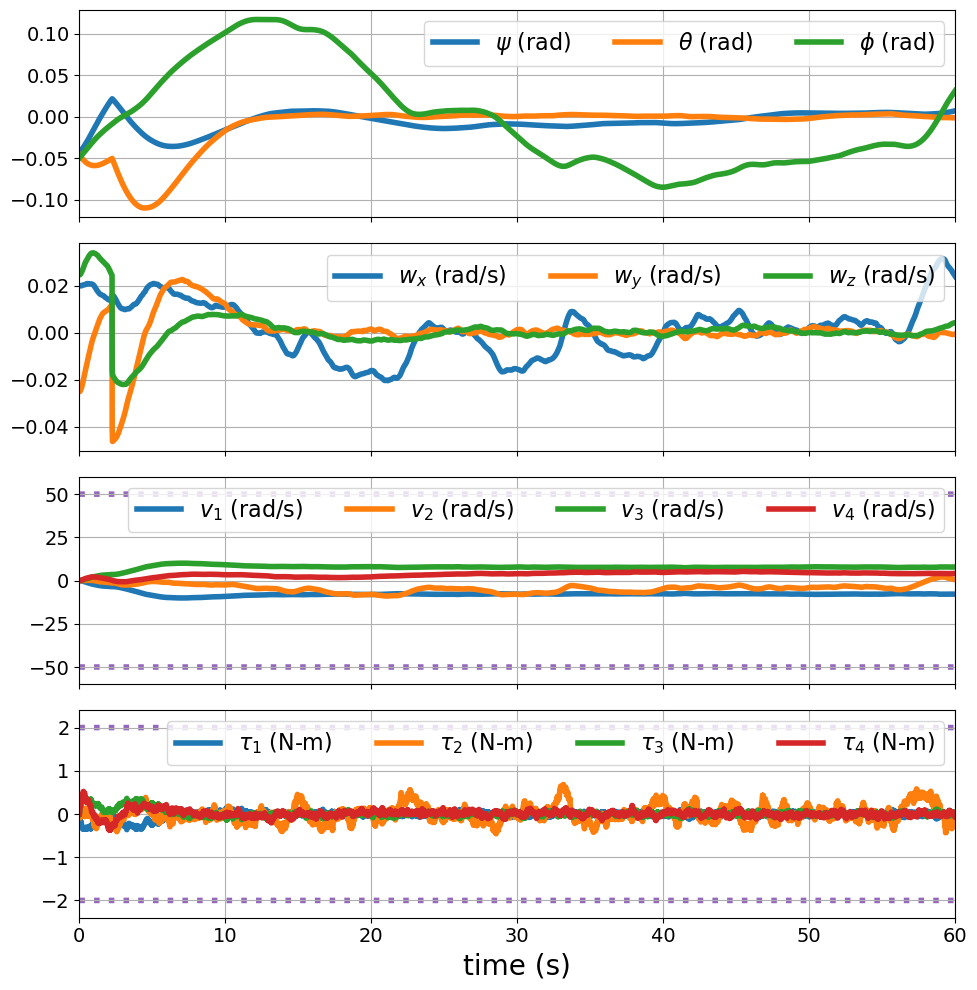

In [117]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [14]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

[[ 0.24102895 -0.15822656  0.03976921  0.12772296 -0.36234634 -0.00378908]
 [ 0.23530943  0.01334944 -0.07939748  0.33543034  0.17161525  0.13547397]
 [ 0.20418315 -0.11301982 -0.0101865   0.45696003 -0.13444933 -0.12328163]
 ...
 [-0.0672127  -0.2462276   0.52631974 -0.41691499  0.73528176 -0.17672971]
 [ 0.15897544 -0.19413385  0.35989292 -0.2454871   0.57647682  0.00228747]
 [-0.14475338 -0.15270694  0.40537635 -0.36186294  0.61594461 -0.16231175]]


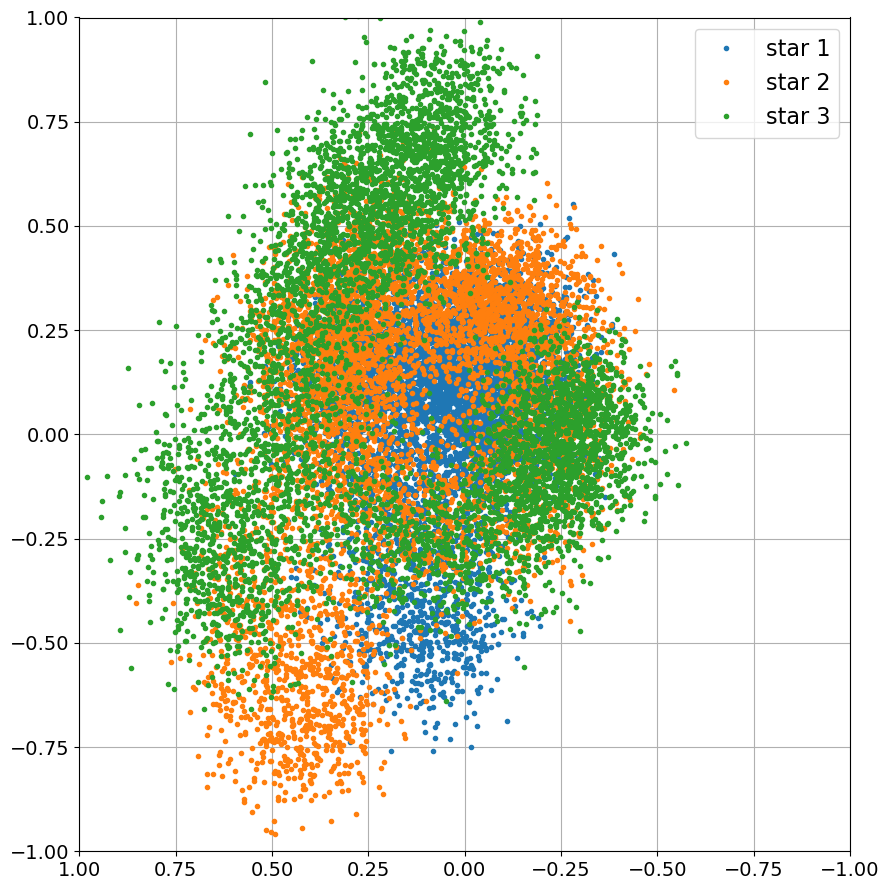

In [57]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
print(data['star_meas'])

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()